In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy
#from scipy import stats
%matplotlib inline
#from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches
from csat2.misc import stats
from csat2 import MODIS
import csat2

_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

In [5]:
def CRE_Plot_total(year):
    import warnings
    print('is it doing?')
    timelen=499
    yedges_net = np.arange(-650,650,1)
    yedges_lw = np.arange(-500,0,1)
    yedges_sw = np.arange(-100,900,1)
    yedges_solar = np.arange(0,1400,5)
    xedges = np.arange(0,timelen+1,1)

    cereshour = 8760
    k=0

    print('enso done')
    tsc = xr.open_mfdataset('/disk1/Users/gah20/TSC_FULL/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62][:2918*3]
    landocean = xr.open_mfdataset('/disk1/Users/gah20/TSC_FULL/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62][:2918*3]
    detinsit = xr.open_mfdataset('/disk1/Users/gah20/TSC_FULL/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62][:2918*3]
    print('tsc done')
    isccp = xr.open_mfdataset('/disk1/Data/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/20*.nc',combine='nested',concat_dim='time')

    taupc = isccp['n_pctaudist'][:2918]
    npcdist = isccp['n_pcdist'][:2918]
    levtau = isccp['levtau'][:2918]
    levpc = isccp['levpc'][:2918]
    tauraw = isccp['tau'][:2918]
    pcraw = isccp['pc'][:2918]
    isccptime = isccp['time'][:2918]
    print('isccp done')

    ds_w = xr.open_mfdataset('/disk1/Data/CERES/CERES_year'+str(year)+'.nc')
    swall = ds_w['toa_sw_all_1h'][:,60:120][:2918*3]
    swclr = ds_w['toa_sw_clr_1h'][:,60:120][:2918*3]
    lwall = ds_w['toa_lw_all_1h'][:,60:120][:2918*3]
    lwclr = ds_w['toa_lw_clr_1h'][:,60:120][:2918*3]

    ds_alb = xr.open_mfdataset('/disk1/Data/CERES/2024_dwld/CERES_year'+str(year)+'.nc')
    solar = ds_alb['toa_solar_all_1h'][:,60:120][:2918*3]
    alb_all = ds_alb['toa_alb_all_1h'][:,60:120][:2918*3]
    alb_clr = ds_alb['toa_alb_clr_1h'][:,60:120][:2918*3]
    timeceres = ds_alb['time'][:]
    print('ceres done')
    #cf = ds_alb['cldarea_total_1h'][:]
    print('all dated loaded in')
    offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))
    if len(isccptime[offset:]) == len(tsc[offset*3:])/3:
        swcldycalc = -(swall[0::3][0:len(isccp['time'][offset:])] - swclr[0::3][0:len(isccp['time'][offset:])])

        meanlw = np.nanmean(lwclr[:],axis=0)
        levels = 5
        lowcldamt = 1

        lowcloudraw = np.nansum(npcdist[offset:,:levels,60:120],axis=1)
        lowcloud_day = np.where(lowcloudraw<0,np.nan,lowcloudraw)
        print('low cloud done')
        solar_t = solar[0::3][0:len(isccptime[offset:])]
        alb_all_t = alb_all[0::3][0:len(isccptime[offset:])]
        alb_clr_t = alb_clr[0::3][0:len(isccptime[offset:])]
        print('doing albedos now')
        alb_all_t_sm = np.where(solar_t<700,np.nan,alb_all_t) 
        alb_clr_t_sm = np.where(solar_t<700,np.nan,alb_clr_t)
        solar_t_sm = np.where(solar_t<700,np.nan,solar_t)
        print('len lowcloud:',len(lowcloud_day[:]))
        print('len alb_all_t_sm:',len(alb_all_t_sm))
        
        low_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm - alb_clr_t_sm,np.nan)
        bkg_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm,np.nan)

        from csat2 import misc
        lstbkgalb = np.zeros((345,25,60,360))
        transpose_bkgalb = np.transpose(np.asarray(bkg_alb), (1, 2, 0))
        for j in range(0,345,1):
            try:
                for i in range(0,25,3):
                    lstbkgalb[j,i] = misc.time.toLocalSolarTime(i,np.arange(0,25,3),np.arange(0,360,1),np.asarray(transpose_bkgalb[:,:,j*8:(j*8)+9]),interpolation='nearest')
            except:
                lstbkgalb[j,i] = lstbkgalb[j-1,i]
            print(j)
        lstbkgalb = np.where(lstbkgalb==0,np.nan,lstbkgalb)

        alb_high_low = alb_all_t - (alb_clr_t + np.nanmean(low_alb,axis=0))
        alb_high_low = np.where(np.isnan(alb_high_low),0,alb_high_low)
        alb_high_bkg = alb_all_t - np.nanmean(np.nanmean(lstbkgalb,axis=0),axis=0)
        alb_high_bkg = np.where(np.isnan(alb_high_bkg),0,alb_high_bkg)
        print('albedos done')
        lwclr_f = np.where(np.isnan(lwclr[0::3][0:len(isccptime[offset:])]),meanlw,lwclr[0::3][0:len(isccptime[offset:])])
        lwcldy = (lwall[0::3][0:len(isccptime[offset:])] - lwclr_f) 
        swcldy_high = solar_t*alb_high_bkg

        tsc_t = (np.asarray(tsc[offset*3::3]))
        tsc_d = np.asarray(np.where(detinsit[offset*3::3]>=0,tsc[offset*3::3],np.nan))
        
        tsc_o = np.asarray(np.where(landocean[offset*3::3]<0,tsc[offset*3::3],np.nan))
        tsc_l = np.asarray(np.where(landocean[offset*3::3]>0,tsc[offset*3::3],np.nan))

        tsc_o_d = np.asarray(np.where(landocean[offset*3::3]<0,tsc_d,np.nan))
        tsc_l_d = np.asarray(np.where(landocean[offset*3::3]>0,tsc_d,np.nan))


        H_lw, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw)) 
        H_sw, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(swcldy_high).flatten(), bins=(xedges,yedges_sw))

        H_sw_det, xedges, yedges_sw = np.histogram2d(tsc_d.flatten(),np.asarray(swcldy_high).flatten(), bins=(xedges,yedges_sw))
        H_lw_det, xedges, yedges_lw = np.histogram2d(tsc_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

        H_lw_o_det, xedges, yedges_lw = np.histogram2d(tsc_o_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
        H_lw_l_det, xedges, yedges_lw = np.histogram2d(tsc_l_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

        H_sw_o_det, xedges, yedges_sw = np.histogram2d(tsc_o_d.flatten(),np.asarray(swcldy_high).flatten(), bins=(xedges,yedges_sw))
        H_sw_l_det, xedges, yedges_sw = np.histogram2d(tsc_l_d.flatten(),np.asarray(swcldy_high).flatten(), bins=(xedges,yedges_sw))

    timelen=499
    print('histograms done')

    H_norm_sw_det = np.zeros((timelen,999))
    H_norm_lw_det = np.zeros((timelen,499))

    H_norm_lw_o_det = np.zeros((timelen,499))
    H_norm_lw_l_det = np.zeros((timelen,499))

    H_norm_sw_o_det = np.zeros((timelen,999))
    H_norm_sw_l_det = np.zeros((timelen,999))



    for i in range(timelen):
        H_norm_sw_det[i] = H_sw_det[i] / np.sum(H_sw_det[i])
        H_norm_lw_det[i] = H_lw_det[i] / np.sum(H_lw_det[i])

        H_norm_lw_o_det[i] = H_lw_o_det[i] / np.sum(H_lw_o_det[i])
        H_norm_lw_l_det[i] = H_lw_l_det[i] / np.sum(H_lw_l_det[i])

        H_norm_sw_o_det[i] = H_sw_o_det[i] / np.sum(H_sw_o_det[i])
        H_norm_sw_l_det[i] = H_sw_l_det[i] / np.sum(H_sw_l_det[i])
    print('doing averages')

    SW_AVERAGE_det = np.zeros((timelen))
    LW_AVERAGE_det = np.zeros((timelen))

    LW_AVERAGE_o_det = np.zeros((timelen))
    LW_AVERAGE_l_det = np.zeros((timelen))
    
    SW_AVERAGE_o_det = np.zeros((timelen))
    SW_AVERAGE_l_det = np.zeros((timelen))

    for i in range(timelen):
        SW_AVERAGE_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det[i])
        LW_AVERAGE_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det[i])

        LW_AVERAGE_o_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_det[i])
        LW_AVERAGE_l_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_det[i])

        SW_AVERAGE_o_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_det[i])
        SW_AVERAGE_l_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_det[i])
        
    print('averages done')

    counts_det = np.histogram(np.asarray(tsc_d).flatten(),bins=np.arange(0,500,1))[0]
    counts_det_o = np.histogram(np.asarray(tsc_o_d).flatten(),bins=np.arange(0,500,1))[0]
    counts_det_l = np.histogram(np.asarray(tsc_l_d).flatten(),bins=np.arange(0,500,1))[0]


    lwsum = np.nansum(LW_AVERAGE_det[:]*(counts_det[:]))/np.nansum(counts_det[:])
    swsum = np.nansum(SW_AVERAGE_det[:]*(counts_det[:]))/np.nansum(counts_det[:])

    lwsum_o = np.nansum(LW_AVERAGE_o_det[:]*(counts_det_o[:]))/np.nansum(counts_det_o[:])
    swsum_o = np.nansum(SW_AVERAGE_l_det[:]*(counts_det_o[:]))/np.nansum(counts_det_o[:])

    lwsum_l = np.nansum(LW_AVERAGE_l_det[:]*(counts_det_l[:]))/np.nansum(counts_det_l[:])
    swsum_l = np.nansum(SW_AVERAGE_l_det[:]*(counts_det_l[:]))/np.nansum(counts_det_l[:])

    totalforcing = lwsum + swsum
    totalforcing_land = lwsum_l + swsum_l
    totalforcing_ocean = lwsum_o + swsum_o

    return totalforcing,totalforcing_land,totalforcing_ocean,LW_AVERAGE_det,SW_AVERAGE_det,LW_AVERAGE_l_det,SW_AVERAGE_l_det,LW_AVERAGE_o_det,SW_AVERAGE_o_det


In [6]:
import warnings
warnings.filterwarnings('ignore')

if __name__ == '__main__':
    p = mp.Pool(2)
    pmap = p.map(CRE_Plot_total,np.arange(2000,2002,1))
    p.close()
    np.save('CRE_Plot_total_2000_2002.npy',pmap)

is it doing?is it doing?

enso doneenso done



tsc done
tsc done
isccp done
ceres done
all dated loaded in
isccp done
ceres done
all dated loaded in
low cloud done
doing albedos now
len lowcloud: 2438
len alb_all_t_sm: 2438
low cloud done
doing albedos now
0
1
2
3
4
5
6
7
8
9
10
11
12
len lowcloud: 2918
len alb_all_t_sm: 2918
13
14
15
16
0
17
1
18
2
19
3
20
4
21
5
22
6
23
7
24
8
25
9
26
10
27
11
28
12
29
13
30
14
31
15
32
16
33
17
34
18
35
19
36
20
37
21
38
22
39
23
40
24
41
25
42
26
43
27
44
28
45
29
46
30
47
31
48
32
49
33
50
34
51
35
52
36
53
37
54
38
55
39
56
57
40
58
41
59
42
60
43
61
44
62
45
63
46
64
47
65
48
66
49
67
50
68
51
69
52
70
53
71
54
72
55
73
56
74
57
75
58
76
59
77
60
78
61
79
62
80
63
81
64
82
65
83
66
84
67
85
68
86
69
87
70
88
71
89
72
90
73
91
74
92
75
93
76
94
77
95
78
96
79
97
80
98
81
99
82
100
83
101
84
102
85
103
86
104
87
105
88
106
89
107
90
108
91
109
92
110
93
111
94
112
95
113
96
114
97
115
98
116
99
117
100
118
101
119
102
120
103
121
104
122
105
123
106
124
107
125
108
126
109
127
110
128
111
129


In [76]:
import warnings
year=2005
print('is it doing?')
timelen=499
yedges_net = np.arange(-650,650,1)
yedges_lw = np.arange(-500,0,1)
yedges_sw = np.arange(-100,900,1)
yedges_solar = np.arange(0,1400,5)
xedges = np.arange(0,timelen+1,1)

cereshour = 8760
k=0

print('enso done')
tsc = xr.open_mfdataset('/disk1/Users/gah20/TSC_2origin/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62][:2918*3]
landocean = xr.open_mfdataset('/disk1/Users/gah20/TSC_2origin/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62][:2918*3]
detinsit = xr.open_mfdataset('/disk1/Users/gah20/TSC_2origin/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62][:2918*3]
convstrength = xr.open_mfdataset('/disk1/Users/gah20/TSC_2origin/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvPc'][:,2:62][:2918*3]

print('tsc done')
isccp = xr.open_mfdataset('/disk1/Data/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/20*.nc',combine='nested',concat_dim='time')

taupc = isccp['n_pctaudist'][:2918]
npcdist = isccp['n_pcdist'][:2918]
levtau = isccp['levtau'][:2918]
levpc = isccp['levpc'][:2918]
tauraw = isccp['tau'][:2918]
pcraw = isccp['pc'][:2918]
isccptime = isccp['time'][:2918]
print('isccp done')

ds_w = xr.open_mfdataset('/disk1/Data/CERES/CERES_year'+str(year)+'.nc')
swall = ds_w['toa_sw_all_1h'][:,60:120][:2918*3]
swclr = ds_w['toa_sw_clr_1h'][:,60:120][:2918*3]
lwall = ds_w['toa_lw_all_1h'][:,60:120][:2918*3]
lwclr = ds_w['toa_lw_clr_1h'][:,60:120][:2918*3]

ds_alb = xr.open_mfdataset('/disk1/Data/CERES/2024_dwld/CERES_year'+str(year)+'.nc')
solar = ds_alb['toa_solar_all_1h'][:,60:120][:2918*3]
alb_all = ds_alb['toa_alb_all_1h'][:,60:120][:2918*3]
alb_clr = ds_alb['toa_alb_clr_1h'][:,60:120][:2918*3]
timeceres = ds_alb['time'][:]
print('ceres done')
#cf = ds_alb['cldarea_total_1h'][:]
print('all dated loaded in')
offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))
if len(isccptime[offset:]) == len(tsc[offset*3:])/3:
    swcldycalc = -(swall[0::3][0:len(isccp['time'][offset:])] - swclr[0::3][0:len(isccp['time'][offset:])])

    meanlw = np.nanmean(lwclr[:],axis=0)
    levels = 5
    lowcldamt = 1

    lowcloudraw = np.nansum(npcdist[offset:,:levels,60:120],axis=1)
    lowcloud_day = np.where(lowcloudraw<0,np.nan,lowcloudraw)
    print('low cloud done')
    solar_t = solar[0::3][0:len(isccptime[offset:])]
    alb_all_t = alb_all[0::3][0:len(isccptime[offset:])]
    alb_clr_t = alb_clr[0::3][0:len(isccptime[offset:])]
    print('doing albedos now')
    alb_all_t_sm = np.where(solar_t<700,np.nan,alb_all_t) 
    alb_clr_t_sm = np.where(solar_t<700,np.nan,alb_clr_t)
    solar_t_sm = np.where(solar_t<700,np.nan,solar_t)
    print('len lowcloud:',len(lowcloud_day[:]))
    print('len alb_all_t_sm:',len(alb_all_t_sm))
    
    low_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm - alb_clr_t_sm,np.nan)
    bkg_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm,np.nan)

    from csat2 import misc
    lstbkgalb = np.zeros((345,25,60,360))
    transpose_bkgalb = np.transpose(np.asarray(bkg_alb), (1, 2, 0))
    for j in range(0,345,1):
        try:
            for i in range(0,25,3):
                lstbkgalb[j,i] = misc.time.toLocalSolarTime(i,np.arange(0,25,3),np.arange(0,360,1),np.asarray(transpose_bkgalb[:,:,j*8:(j*8)+9]),interpolation='nearest')
        except:
            lstbkgalb[j,i] = lstbkgalb[j-1,i]
        print(j)
    lstbkgalb = np.where(lstbkgalb==0,np.nan,lstbkgalb)

    alb_high_low = alb_all_t - (alb_clr_t + np.nanmean(low_alb,axis=0))
    alb_high_low = np.where(np.isnan(alb_high_low),0,alb_high_low)
    alb_high_bkg = alb_all_t - np.nanmean(np.nanmean(lstbkgalb,axis=0),axis=0)
    alb_high_bkg = np.where(np.isnan(alb_high_bkg),0,alb_high_bkg)
    print('albedos done')
    lwclr_f = np.where(np.isnan(lwclr[0::3][0:len(isccptime[offset:])]),meanlw,lwclr[0::3][0:len(isccptime[offset:])])
    lwcldy = (lwall[0::3][0:len(isccptime[offset:])] - lwclr_f) 
    swcldy_high = solar_t*alb_high_bkg

    #tsc_t = (np.asarray(tsc[offset*3::3]))
    tsc = np.where((convstrength>-750)&(convstrength<0),tsc,np.nan)
    tsc_d = np.asarray(np.where(detinsit[offset*3::3]>=0,tsc[offset*3::3],np.nan))
    
    tsc_o = np.asarray(np.where(landocean[offset*3::3]<0,tsc[offset*3::3],np.nan))
    tsc_l = np.asarray(np.where(landocean[offset*3::3]>0,tsc[offset*3::3],np.nan))

    tsc_o_d = np.asarray(np.where(landocean[offset*3::3]<0,tsc_d,np.nan))
    tsc_l_d = np.asarray(np.where(landocean[offset*3::3]>0,tsc_d,np.nan))


    H_sw_det, xedges, yedges_sw = np.histogram2d(tsc_d.flatten(),np.asarray(swcldy_high).flatten(), bins=(xedges,yedges_sw))
    H_lw_det, xedges, yedges_lw = np.histogram2d(tsc_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

    H_lw_o_det, xedges, yedges_lw = np.histogram2d(tsc_o_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
    H_lw_l_det, xedges, yedges_lw = np.histogram2d(tsc_l_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

    H_sw_o_det, xedges, yedges_sw = np.histogram2d(tsc_o_d.flatten(),np.asarray(swcldy_high).flatten(), bins=(xedges,yedges_sw))
    H_sw_l_det, xedges, yedges_sw = np.histogram2d(tsc_l_d.flatten(),np.asarray(swcldy_high).flatten(), bins=(xedges,yedges_sw))

timelen=499
print('histograms done')

H_norm_sw_det = np.zeros((timelen,999))
H_norm_lw_det = np.zeros((timelen,499))

H_norm_lw_o_det = np.zeros((timelen,499))
H_norm_lw_l_det = np.zeros((timelen,499))

H_norm_sw_o_det = np.zeros((timelen,999))
H_norm_sw_l_det = np.zeros((timelen,999))



for i in range(timelen):
    H_norm_sw_det[i] = H_sw_det[i] / np.sum(H_sw_det[i])
    H_norm_lw_det[i] = H_lw_det[i] / np.sum(H_lw_det[i])

    H_norm_lw_o_det[i] = H_lw_o_det[i] / np.sum(H_lw_o_det[i])
    H_norm_lw_l_det[i] = H_lw_l_det[i] / np.sum(H_lw_l_det[i])

    H_norm_sw_o_det[i] = H_sw_o_det[i] / np.sum(H_sw_o_det[i])
    H_norm_sw_l_det[i] = H_sw_l_det[i] / np.sum(H_sw_l_det[i])
print('doing averages')

SW_AVERAGE_det = np.zeros((timelen))
LW_AVERAGE_det = np.zeros((timelen))

LW_AVERAGE_o_det = np.zeros((timelen))
LW_AVERAGE_l_det = np.zeros((timelen))

SW_AVERAGE_o_det = np.zeros((timelen))
SW_AVERAGE_l_det = np.zeros((timelen))

for i in range(timelen):
    SW_AVERAGE_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det[i])
    LW_AVERAGE_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det[i])

    LW_AVERAGE_o_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_det[i])
    LW_AVERAGE_l_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_det[i])

    SW_AVERAGE_o_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_det[i])
    SW_AVERAGE_l_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_det[i])
    
print('averages done')

counts_det = np.histogram(np.asarray(tsc_d).flatten(),bins=np.arange(0,500,1))[0]
counts_det_o = np.histogram(np.asarray(tsc_o_d).flatten(),bins=np.arange(0,500,1))[0]
counts_det_l = np.histogram(np.asarray(tsc_l_d).flatten(),bins=np.arange(0,500,1))[0]


lwsum = np.nansum(LW_AVERAGE_det[:]*(counts_det[:]))/np.nansum(counts_det[:])
swsum = np.nansum(SW_AVERAGE_det[:]*(counts_det[:]))/np.nansum(counts_det[:])

lwsum_o = np.nansum(LW_AVERAGE_o_det[:]*(counts_det_o[:]))/np.nansum(counts_det_o[:])
swsum_o = np.nansum(SW_AVERAGE_o_det[:]*(counts_det_o[:]))/np.nansum(counts_det_o[:])

lwsum_l = np.nansum(LW_AVERAGE_l_det[:]*(counts_det_l[:]))/np.nansum(counts_det_l[:])
swsum_l = np.nansum(SW_AVERAGE_l_det[:]*(counts_det_l[:]))/np.nansum(counts_det_l[:])

totalforcing = lwsum + swsum
totalforcing_land = lwsum_l + swsum_l
totalforcing_ocean = lwsum_o + swsum_o

#return totalforcing,totalforcing_land,totalforcing_ocean,LW_AVERAGE_det,SW_AVERAGE_det,LW_AVERAGE_l_det,SW_AVERAGE_l_det,LW_AVERAGE_o_det,SW_AVERAGE_o_det

is it doing?
enso done
tsc done
isccp done
ceres done
all dated loaded in
low cloud done
doing albedos now
len lowcloud: 2918
len alb_all_t_sm: 2918
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
2

In [78]:
totalforcing_midstrong = totalforcing

In [80]:
print(totalforcing_strong)
print(totalforcing_midstrong)

9.594284593338088
5.480621534545165


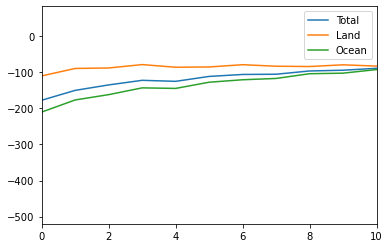

In [77]:
plt.plot(SW_AVERAGE_det,label='Total')
plt.plot(SW_AVERAGE_l_det,label='Land')
plt.plot(SW_AVERAGE_o_det,label='Ocean')
plt.xlim(0,10)
#plt.ylim(-100,55)
plt.legend()

In [43]:
lwsum = np.nansum(LW_AVERAGE_det[:]*(counts_det[:]))/np.nansum(counts_det[:])
swsum = np.nansum(SW_AVERAGE_det[:]*(counts_det[:]))/np.nansum(counts_det[:])

lwsum_o = np.nansum(LW_AVERAGE_o_det[:]*(counts_det_o[:]))/np.nansum(counts_det_o[:])
swsum_o = np.nansum(SW_AVERAGE_o_det[:]*(counts_det_o[:]))/np.nansum(counts_det_o[:])

lwsum_l = np.nansum(LW_AVERAGE_l_det[:]*(counts_det_l[:]))/np.nansum(counts_det_l[:])
swsum_l = np.nansum(SW_AVERAGE_l_det[:]*(counts_det_l[:]))/np.nansum(counts_det_l[:])

totalforcing = lwsum + swsum
totalforcing_land = lwsum_l + swsum_l
totalforcing_ocean = lwsum_o + swsum_o

In [47]:
totalforcing_land

15.043070468471157

(0.0, 120.0)

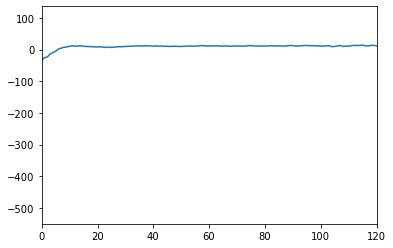

In [49]:
plt.plot(LW_AVERAGE_det+SW_AVERAGE_det)
plt.xlim(0,120)

(125.0, 150.0)

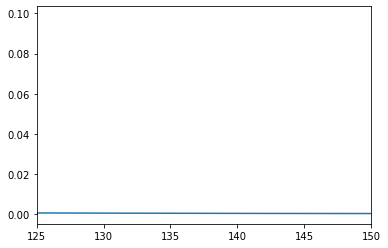

In [59]:
plt.plot((counts_det[0:200]/np.nansum(counts_det[0:200])))
plt.xlim(125,150)